# REFUGERestrooms.org, a Requests-Based API Example

REFUGE Restrooms provides access to a database of safe restroom access for transgender, intersex, and gender nonconforming individuals. Individuals can search for safe access in their local areas or areas of interest for travel (similar work is available for identifying ADA-compliant spaces, so people with disabilities may plan travel accordingly).

We use the [Requests library](https://docs.python-requests.org/en/latest/) for connecting to this RESTful API via HTTP requests.

Relevant resources include:
- [refugerestrooms.org API Documentation](https://www.refugerestrooms.org/api/docs/) - Documentation on the API and its endpoints

In [1]:
%matplotlib inline

In [2]:
import time
import json
import requests

import pandas as pd

import matplotlib.pyplot as plt

## Test the API

To test whether the API works, let's try to pull some data about airports.

In [3]:
api_prefix = "https://www.refugerestrooms.org/api/v1"

resp = requests.get(
    api_prefix + "/restrooms/by_location/",
    params={
        "page": 1,
        "per_page": 100,
        "offset": 0,
        "lat": 38.98531993986008, # Latitude of UMD
        "lng": -76.94942407326441 # Longitude of UMD
    }
)

In [4]:
resp.status_code # Status code 200 means the request was successful
# See https://developer.mozilla.org/en-US/docs/Web/HTTP/Status for all HTTP statuses

200

In [5]:
resp.headers['content-type'] # If you're using a RESTful API, odds are the content type will be JSON

'application/json'

In [6]:
resp.content # We can get the raw content, regardless of its type

b'[{"id":6021,"name":"Casey\'s Coffee","street":"3711 Campus Drive","city":"College Park","state":"MD","accessible":true,"unisex":true,"directions":"In back of shop, grade level","comment":"Very clean. At edge of University of Maryland campus, 1 block from bus stop.","latitude":38.98464269999999,"longitude":-76.9507615,"created_at":"2014-06-06T13:20:28.126Z","updated_at":"2014-06-06T13:20:28.126Z","downvote":1,"upvote":0,"country":"United States","changing_table":false,"edit_id":6021,"approved":true,"distance":0.0857262579064577,"bearing":"243.14347259291"},{"id":4791,"name":"Adele H. Stamp Student Union","street":"Campus Drive","city":"College Park","state":"MD","accessible":true,"unisex":true,"directions":"On the basement level, near the TerpZone. ","comment":"","latitude":38.98518929999999,"longitude":-76.9466113,"created_at":"2014-02-10T15:13:31.049Z","updated_at":"2014-03-20T13:31:55.917Z","downvote":2,"upvote":7,"country":"USA","changing_table":false,"edit_id":4791,"approved":tru

In [7]:
resp_obj = resp.json() # If it is JSON, we can parse it directly

In [8]:
print("Number of Hits:", len(resp_obj))

Number of Hits: 100


In [9]:
for restroom in resp_obj:
    print(json.dumps(restroom, indent=2))

{
  "id": 6021,
  "name": "Casey's Coffee",
  "street": "3711 Campus Drive",
  "city": "College Park",
  "state": "MD",
  "accessible": true,
  "unisex": true,
  "directions": "In back of shop, grade level",
  "comment": "Very clean. At edge of University of Maryland campus, 1 block from bus stop.",
  "latitude": 38.98464269999999,
  "longitude": -76.9507615,
  "created_at": "2014-06-06T13:20:28.126Z",
  "updated_at": "2014-06-06T13:20:28.126Z",
  "downvote": 1,
  "upvote": 0,
  "country": "United States",
  "changing_table": false,
  "edit_id": 6021,
  "approved": true,
  "distance": 0.0857262579064577,
  "bearing": "243.14347259291"
}
{
  "id": 4791,
  "name": "Adele H. Stamp Student Union",
  "street": "Campus Drive",
  "city": "College Park",
  "state": "MD",
  "accessible": true,
  "unisex": true,
  "directions": "On the basement level, near the TerpZone. ",
  "comment": "",
  "latitude": 38.98518929999999,
  "longitude": -76.9466113,
  "created_at": "2014-02-10T15:13:31.049Z",
  

## Relative Accessibility of Locations

Each restroom entry has an associated `distance` field that specifies how far the entry is from the point of query.

This value allows us to measure the average distance of the first `k` restrooms, which might be a useful metric to measure how safe and accessible a given area might be. That is, we can ask whether a place like College Park, MD is more or less safe and accessible than college towns in other parts of the country.

Note that such metrics are necessarily biased by population size, as larger schools or schools in larger cities may be more likely to have may such restrooms compared to smaller schools or smaller towns. There is little guarantee that this dataset is complete as well.

In [10]:
result_map = {}

for loc,(lat,lon) in [
    ("UMD", (38.98531993986008, -76.94942407326441)),
    ("NJIT", (40.742094188252445, -74.17950489209532)),
    ("NYU", (40.72952963981787, -73.9963965288707)),
    ("Cornell", (42.45333835478907, -76.47401768596698)),
    ("UAB", (33.501892362478735, -86.80625896306735)),
    ("Alabama", (33.20947076479713, -87.54715066647096)),
    ("UT-Austin", (30.284890687745584, -97.73402451558707)),
    
]:
    print("Location:", loc)
    resp = requests.get(
        api_prefix + "/restrooms/by_location/",
        params={
            "page": 1,
            "per_page": 100,
            "offset": 0,
            "lat": lat,
            "lng": lon,
        }
    )
    
    assert resp.status_code == 200
    assert resp.headers["content-type"] == "application/json"
    
    # Get distances for each restroom
    this_restroom_list = resp.json()
    distances = [r["distance"] for r in this_restroom_list]
    
    # Add the list of distances to our dictionary
    result_map[loc] = distances
    
    # Be nice to the server
    time.sleep(1)

Location: UMD
Location: NJIT
Location: NYU
Location: Cornell
Location: UAB
Location: Alabama
Location: UT-Austin


In [11]:
result_map

{'UMD': [0.0857262579064577,
  0.1513344405488323,
  0.2900323215417397,
  0.2988726397551863,
  0.33263424617660875,
  0.3471028295963474,
  0.44292780119682085,
  0.46263384646904354,
  0.512070455180945,
  0.5289051958985944,
  0.6717727863294912,
  0.6717727863294912,
  0.7030875290414225,
  0.7511437532643169,
  0.9138636905452812,
  0.9152884569527813,
  0.9152884569527813,
  0.9294648406864595,
  0.9572643062384169,
  1.236443273298357,
  1.3237972234612103,
  1.4269357253594939,
  1.4565305890857112,
  2.512112098281748,
  2.576583964624367,
  3.088170569675693,
  3.196171469057789,
  3.300797918617993,
  3.364743680292116,
  3.410956612614388,
  3.432525525617256,
  3.444730878816665,
  3.444730878816665,
  3.444730878816665,
  3.4554489310321364,
  3.4672202146361517,
  3.484102656583089,
  3.484102656583089,
  3.5300758353875286,
  3.5936755512875753,
  3.6113881424287113,
  3.6824166376796996,
  3.7654625737615603,
  3.8563294889028694,
  3.8563294889028694,
  3.92642031716

In [12]:
df = pd.DataFrame(list(result_map.values())).T
df.columns=list(result_map.keys())

df

,UMD,NJIT,NYU,Cornell,UAB,Alabama,UT-Austin
0,0.085726,0.409158,0.036680,0.106684,0.057187,0.072393,0.083956
1,0.151334,0.434347,0.043749,0.359977,0.109070,0.173634,0.112529
2,0.290032,1.247552,0.046103,0.414635,0.163645,0.210328,0.117455
3,0.298873,2.116884,0.046103,0.439522,0.268527,0.210328,0.119002
4,0.332634,2.116884,0.046103,0.509767,0.296808,0.210328,0.154356
...,...,...,...,...,...,...,...
95,5.567014,8.642801,0.498782,15.689341,NaN,NaN,1.141892
96,5.567014,8.642801,0.507568,15.820658,NaN,NaN,1.151522
97,5.567014,8.680766,0.512804,16.364697,NaN,NaN,1.152449
98,5.569400,8.731172,0.521322,16.796693,NaN,NaN,1.158366


Text(0, 0.5, 'Distance')

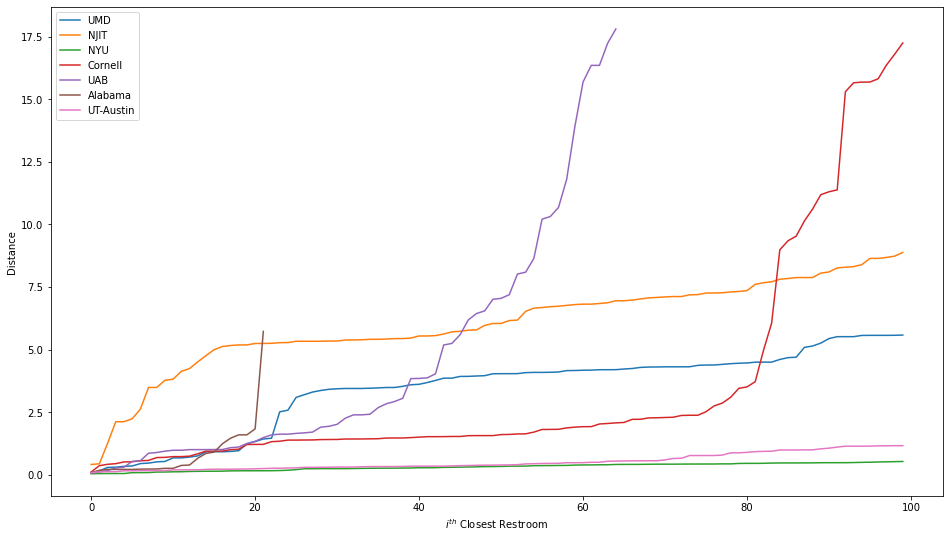

In [13]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

df.plot(ax=ax)
ax.set_xlabel(r"$i^{th}$ Closest Restroom")
ax.set_ylabel("Distance")